In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
import numpy as np
import json
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [47]:
# STEP 1: Load the dataset

# Dataset: Sarcasm Headlines Dataset (downloadable here: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection?resource=download)
# Each line is a JSON object: {"headline": "text...", "is_sarcastic": 0 or 1}

with open("Sarcasm_Headlines_Dataset.json", 'r') as f:
    data = [json.loads(line) for line in f]

texts = [item['headline'] for item in data]
labels = np.array([item['is_sarcastic'] for item in data])

In [48]:
# STEP 2: Preprocess text

def clean_text(text):
    text = text.lower() # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation
    return text

texts = [clean_text(t) for t in texts] # iterates through all texts, cleaning each one

In [49]:
# STEP 3: Tokenize and pad

vocab_size = 10000  # limit vocabulary to prevent overfitting
max_length = 20     # reasonable for short headlines
oov_token = "<OOV>" # token for out-of-vocabulary words

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token) # initialize tokenizer
tokenizer.fit_on_texts(texts) # fit tokenizer on texts

sequences = tokenizer.texts_to_sequences(texts) # convert texts to sequences of integers
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post') # pad sequences

In [50]:
# STEP 4: Split train/test

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.3, random_state=8400
)

In [51]:
# STEP 5: Build the model

model = models.Sequential([
    layers.Embedding(vocab_size, 64, input_length=max_length),
    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)), # Bidirection allows the model to learn from both past and future context
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3), # randomly drop 30% of neurons to prevent overfitting
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

e:\Documents\Algonquin\Term 5\CST8400\CST8400_Lab6_MichaelDagher\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
# STEP 6: Train the model

history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    batch_size=64,
    verbose=1
)

Epoch 1/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7893 - loss: 0.4303 - val_accuracy: 0.8514 - val_loss: 0.3386
Epoch 2/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9053 - loss: 0.2398 - val_accuracy: 0.8477 - val_loss: 0.3513
Epoch 3/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9393 - loss: 0.1607 - val_accuracy: 0.8531 - val_loss: 0.3791
Epoch 4/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9621 - loss: 0.1070 - val_accuracy: 0.8490 - val_loss: 0.4381
Epoch 5/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9736 - loss: 0.0748 - val_accuracy: 0.8456 - val_loss: 0.5158


In [53]:
# STEP 7: Evaluate

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.3f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8456 - loss: 0.5158
Test Accuracy: 0.846


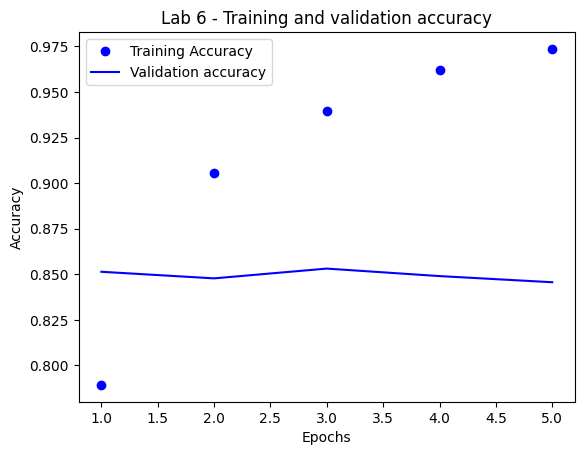

In [59]:
# STEP 8: Analyze training history

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Lab 6 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# STEP 9: Try a few samples

def predict_sarcasm(sentence):
    sentence = clean_text(sentence)
    seq = tokenizer.texts_to_sequences([sentence])
    pad = pad_sequences(seq, maxlen=max_length, padding='post')
    pred = model.predict(pad)[0][0]
    print(f"'{sentence}' → {'Sarcastic' if pred > 0.5 else 'Not Sarcastic'} ({pred:.2f})")

predict_sarcasm("Politician promises to fix everything, world breathes a sigh of relief.")
predict_sarcasm("Local business promises to stop scamming customers if they pay more.")
predict_sarcasm("Complex AI model fails to predict sarcasm, experts confounded")
predict_sarcasm("Students everywhere agree, CST8413 is their favorite course!")
predict_sarcasm("Experts agree eight o'clock in the morning is the best time for learning and productivity.")
predict_sarcasm("Experts agree 8am is the best time for learning and productivity.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
'politician promises to fix everything world breathes a sigh of relief' → Sarcastic (0.80)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
'local business promises to stop scamming customers if they pay more' → Sarcastic (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
'complex ai model fails to predict sarcasm experts confounded' → Sarcastic (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
'students everywhere agree cst is their favorite course' → Not Sarcastic (0.15)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
'experts agree eight oclock in the morning is the best time for learning and productivity' → Sarcastic (0.88)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
'experts agree am is the best time for learning and productivity' → Not Sarcastic (0.05)
